# Prep and filter data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc

from ALLCools.clustering import \
    tsne, \
    significant_pc_test, \
    filter_regions, \
    remove_black_list_region, \
    lsi, \
    binarize_matrix
from ALLCools.plot import *
from ALLCools.mcds import MCDS
from pathlib import Path

In [2]:
import os
from pathlib import Path
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus/snm3c/hh_micro_mono/")
os.chdir(root_dir / "DMR_classifier")

In [3]:
meta_path = "allc_meta.tsv"
mcds_path = "DMR_5k.mcds"
var_dim = "chrom5k"
obs_dim = "cell"

In [4]:
metadata = pd.read_csv(meta_path, sep="\t", header=0, index_col=0)

In [5]:
metadata["celltype"].value_counts()

Oligo           13142
Astro            2485
Mono1            1796
Micro1           1388
SUB              1315
Micro2           1246
Tnaive_CD4_1     1134
OPC              1118
Marc_HT           755
Marc_Nrv          740
Mac_Alv           567
NK_CD16_Bld       458
Mono2             385
Tnaive_CD4_2      364
Fibro_Mus         344
DG                311
VIP               306
Endo-VLMC         246
Tnaive_CD8_1      221
Tnaive_CD8_2      196
SST               195
PVALB             180
NR2F2-LAMP5       176
infant_MGC-1      174
Mast_Skn          160
CA                132
NK_CD56_Bld       121
Mono_HT           120
Endo_Lym_Skn      116
NK_CK56_Skn       105
Name: celltype, dtype: int64

In [6]:
mcds = MCDS.open(mcds_path, obs_dim=obs_dim, var_dim=var_dim)

In [7]:
mcds.add_cell_metadata(metadata)

In [8]:
mcds

<xarray.MCDS>
Dimensions:                    (cell: 29996, chrom5k: 642098, count_type: 2,
                                mc_type: 2)
Coordinates:
  * cell                       (cell) object 'hc1153-1-2-D12-AD002' ... 'allc...
  * chrom5k                    (chrom5k) <U27 'chr1_0' ... 'chrY_KI270740v1_r...
    chrom5k_chrom              (chrom5k) <U23 'chr1' ... 'chrY_KI270740v1_ran...
    chrom5k_end                (chrom5k) int64 5000 10000 15000 ... 35000 37240
    chrom5k_start              (chrom5k) int64 0 5000 10000 ... 30000 35000
  * count_type                 (count_type) <U3 'mc' 'cov'
  * mc_type                    (mc_type) <U3 'CGN' 'CHN'
    cell_allc_path             (cell) object '/tscc/projects/ps-epigen/users/...
    cell_celltype              (cell) object 'Oligo' 'Astro' ... 'infant_MGC-1'
    cell_total_cov             (cell) int64 72792 78094 79141 ... 122640 324434
    cell_total_cov_chrom5k     (cell) int64 415382 445909 ... 694070 1772957
Data variables:
    chrom5k_da                 (cell, chrom5k, mc_type, count_type) uint32 dask.array<chunksize=(7, 80263, 1, 1), meta=np.ndarray>
    chrom5k_da_CGN-hypo-score  (cell, chrom5k) float16 dask.array<chunksize=(7, 80263), meta=np.ndarray>
    chrom5k_da_CHN-hypo-score  (cell, chrom5k) float16 dask.array<chunksize=(7, 80263), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom5k

## Some check

In [9]:
## Blacklist regions and Sex chromosomes already removed

In [10]:
import xarray as xr

In [11]:
# First plot the total read counts for each cell grouped by cell type
sel_da = mcds["chrom5k_da"].sel(mc_type="CGN", count_type="cov")
total_cov_per_cell = sel_da.sum(dim="chrom5k").to_pandas()
total_cov_per_cell.name = "total_cov_chrom5k"

/tscc/nfs/home/biy022/miniconda3/envs/allcools/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [12]:
total_cov_per_cell

cell
hc1153-1-2-D12-AD002                            415382
hc1153-1-2-D12-AD012                            445909
hc1153-1-2-D12-AD010                            451981
hc1153-1-2-D12-AD006                            440186
hc1153-1-2-D12-AD004                            410427
                                                ...   
allc_210830-UA19-27-HPC-1-B07_H22_indexed      1185053
allc_20211029-UA19-27-HPC-2-A11_K18_indexed    4085307
allc_210830-UA19-27-HPC-1-B07_E22_indexed       859332
allc_20211130-UA19-27-HPC-8-B08_N1_indexed      694070
allc_20211029-UA19-27-HPC-3-A10_O11_indexed    1772957
Name: total_cov_chrom5k, Length: 29996, dtype: uint64

In [14]:
# metadata = metadata.join(total_cov_per_cell)
metadata.to_csv("allc_meta.tsv", sep="\t", header=True, index=True)

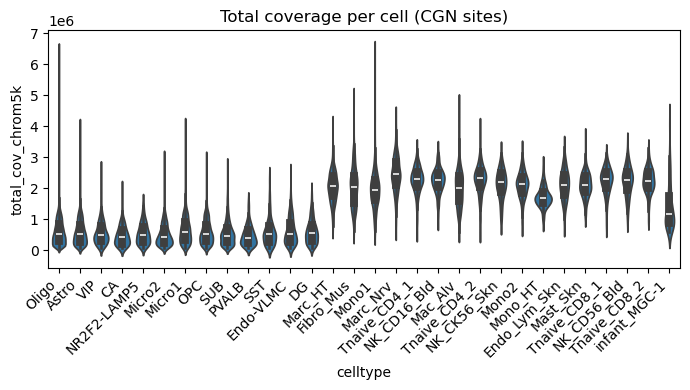

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
sns.violinplot(data=metadata, x="celltype", y="total_cov_chrom5k", inner="box")
plt.xticks(rotation=45, ha="right")
plt.title("Total coverage per cell (CGN sites)")
plt.tight_layout()
plt.show()

# Downsample cell types to at most 500

In [17]:
nsample = 500
meta_sub = (
    metadata.groupby("celltype", group_keys=False).
        apply(lambda x: x.sample(n=min(len(x), nsample), random_state=42))
)
meta_sub = pd.read_csv("dmr_regions-CGN_hypo_score-meta_sub.tsv", sep="\t", header=0, index_col=0)

In [18]:
meta_sub["celltype"].value_counts()

Astro           500
Micro2          500
Tnaive_CD4_1    500
SUB             500
Oligo           500
OPC             500
Mac_Alv         500
Marc_HT         500
Marc_Nrv        500
Mono1           500
Micro1          500
NK_CD16_Bld     458
Mono2           385
Tnaive_CD4_2    364
Fibro_Mus       344
DG              311
VIP             306
Endo-VLMC       246
Tnaive_CD8_1    221
Tnaive_CD8_2    196
SST             195
PVALB           180
NR2F2-LAMP5     176
infant_MGC-1    174
Mast_Skn        160
CA              132
NK_CD56_Bld     121
Mono_HT         120
Endo_Lym_Skn    116
NK_CK56_Skn     105
Name: celltype, dtype: int64

In [19]:
mcds = mcds.sel({obs_dim: meta_sub.index})

In [20]:
mcds

<xarray.MCDS>
Dimensions:                    (cell: 9810, chrom5k: 642098, count_type: 2,
                                mc_type: 2)
Coordinates:
  * cell                       (cell) object 'm5551-1-2-H7-AD012' ... 'allc_2...
  * chrom5k                    (chrom5k) <U27 'chr1_0' ... 'chrY_KI270740v1_r...
    chrom5k_chrom              (chrom5k) <U23 'chr1' ... 'chrY_KI270740v1_ran...
    chrom5k_end                (chrom5k) int64 5000 10000 15000 ... 35000 37240
    chrom5k_start              (chrom5k) int64 0 5000 10000 ... 30000 35000
  * count_type                 (count_type) <U3 'mc' 'cov'
  * mc_type                    (mc_type) <U3 'CGN' 'CHN'
    cell_allc_path             (cell) object '/tscc/projects/ps-epigen/users/...
    cell_celltype              (cell) object 'Astro' 'Astro' ... 'infant_MGC-1'
    cell_total_cov             (cell) int64 120378 176157 ... 163546 112473
    cell_total_cov_chrom5k     (cell) int64 703879 1022188 ... 910216 630163
Data variables:
    chrom5k_da                 (cell, chrom5k, mc_type, count_type) uint32 dask.array<chunksize=(1, 80263, 1, 1), meta=np.ndarray>
    chrom5k_da_CGN-hypo-score  (cell, chrom5k) float16 dask.array<chunksize=(1, 80263), meta=np.ndarray>
    chrom5k_da_CHN-hypo-score  (cell, chrom5k) float16 dask.array<chunksize=(1, 80263), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  chrom5k

In [22]:
# Raw frac
da = mcds["chrom5k_da"]
mc = da.sel(mc_type="CGN", count_type="mc")
cov = da.sel(mc_type="CGN", count_type="cov")
beta = mc / cov
beta = beta.where(~np.isnan(beta), 0.5)
beta = beta.clip(0, 1)

In [23]:
import xarray as xr
beta_cat = xr.full_like(beta, 0)
beta_cat = xr.where(beta > 0.5, 1, beta_cat)
beta_cat = xr.where(beta < 0.5, -1, beta_cat)
has_1 = (beta_cat == 1).any(dim="cell")
has_neg1 = (beta_cat == -1).any(dim="cell")
selected_regions = has_1 & has_neg1

In [24]:
beta_cat

<xarray.DataArray 'chrom5k_da' (cell: 9810, chrom5k: 642098)>
dask.array<where, shape=(9810, 642098), dtype=float64, chunksize=(2, 80263), chunktype=numpy.ndarray>
Coordinates:
  * cell                    (cell) object 'm5551-1-2-H7-AD012' ... 'allc_2021...
  * chrom5k                 (chrom5k) <U27 'chr1_0' ... 'chrY_KI270740v1_rand...
    chrom5k_chrom           (chrom5k) <U23 'chr1' ... 'chrY_KI270740v1_random'
    chrom5k_end             (chrom5k) int64 5000 10000 15000 ... 35000 37240
    chrom5k_start           (chrom5k) int64 0 5000 10000 ... 25000 30000 35000
    mc_type                 <U3 'CGN'
    cell_allc_path          (cell) object '/tscc/projects/ps-epigen/users/biy...
    cell_celltype           (cell) object 'Astro' 'Astro' ... 'infant_MGC-1'
    cell_total_cov          (cell) int64 120378 176157 99478 ... 163546 112473
    cell_total_cov_chrom5k  (cell) int64 703879 1022188 574329 ... 910216 630163

In [25]:
from scipy import sparse
beta_cat_filtered = beta_cat.sel(chrom5k=selected_regions)
beta_cat_filtered = beta_cat_filtered.transpose("cell", "chrom5k")
X_sparse = sparse.csr_matrix(beta_cat_filtered.values)

In [26]:
adata = anndata.AnnData(
    X=X_sparse,
    obs=pd.DataFrame(index=beta_cat_filtered.coords["cell"].values),
    var=pd.DataFrame(index=beta_cat_filtered.coords["chrom5k"].values),
)

In [27]:
adata

AnnData object with n_obs × n_vars = 9810 × 606688

In [28]:
adata.obs["celltype"] = meta_sub.loc[adata.obs_names, "celltype"].copy()

In [29]:
adata.write_h5ad("chrom5k-CGN_beta_trinarized.h5ad")

### Subset all micro1 and micro2 for test trinarization

In [9]:
micro_meta = metadata[metadata["celltype"].isin(["Micro1", "Micro2"])]

In [10]:
mcds = mcds.sel({obs_dim: micro_meta.index})

In [11]:
# Raw frac
da = mcds["chrom5k_da"]
mc = da.sel(mc_type="CGN", count_type="mc")
cov = da.sel(mc_type="CGN", count_type="cov")
beta = mc / cov
beta = beta.where(~np.isnan(beta), 0.5)
beta = beta.clip(0, 1)

In [12]:
import xarray as xr
beta_cat = xr.full_like(beta, 0)
beta_cat = xr.where(beta > 0.5, 1, beta_cat)
beta_cat = xr.where(beta < 0.5, -1, beta_cat)

In [13]:
tri_ds_adata = sc.read_h5ad("chrom5k-CGN_beta_trinarized.h5ad")
selected_regions = tri_ds_adata.var_names

In [14]:
len(selected_regions)

606688

In [15]:
from scipy import sparse
beta_cat_filtered = beta_cat.sel(chrom5k=selected_regions)
beta_cat_filtered = beta_cat_filtered.transpose("cell", "chrom5k")
X_sparse = sparse.csr_matrix(beta_cat_filtered.values)

/tscc/nfs/home/biy022/miniconda3/envs/allcools/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [16]:
adata = anndata.AnnData(
    X=X_sparse,
    obs=pd.DataFrame(index=beta_cat_filtered.coords["cell"].values),
    var=pd.DataFrame(index=beta_cat_filtered.coords["chrom5k"].values),
)

In [17]:
adata

AnnData object with n_obs × n_vars = 2634 × 606688

In [18]:
adata.obs["celltype"] = metadata.loc[adata.obs_names, "celltype"].copy()

In [19]:
adata.obs["celltype"].unique()

array(['Micro2', 'Micro1'], dtype=object)

In [20]:
adata.write_h5ad("chrom5k-CGN_beta_trinarized-Micro_subtypes_test.h5ad")